# **Question 1**

--- Training Model 1: Data-Driven NN ---
Model: Data-Only, Epoch 1000/10000, Loss: 0.000355
Model: Data-Only, Epoch 2000/10000, Loss: 0.000241
Model: Data-Only, Epoch 3000/10000, Loss: 0.000132
Model: Data-Only, Epoch 4000/10000, Loss: 0.000092
Model: Data-Only, Epoch 5000/10000, Loss: 0.000076
Model: Data-Only, Epoch 6000/10000, Loss: 0.000060
Model: Data-Only, Epoch 7000/10000, Loss: 0.000039
Model: Data-Only, Epoch 8000/10000, Loss: 0.000054
Model: Data-Only, Epoch 9000/10000, Loss: 0.000013
Model: Data-Only, Epoch 10000/10000, Loss: 0.000009

--- Training Model 2: PINN ---
Model: PINN, Epoch 1000/10000, Loss: 0.002886
Model: PINN, Epoch 2000/10000, Loss: 0.001352
Model: PINN, Epoch 3000/10000, Loss: 0.000903
Model: PINN, Epoch 4000/10000, Loss: 0.000738
Model: PINN, Epoch 5000/10000, Loss: 0.000594
Model: PINN, Epoch 6000/10000, Loss: 0.000465
Model: PINN, Epoch 7000/10000, Loss: 0.000356
Model: PINN, Epoch 8000/10000, Loss: 0.000290
Model: PINN, Epoch 9000/10000, Loss: 0.000229
Mo

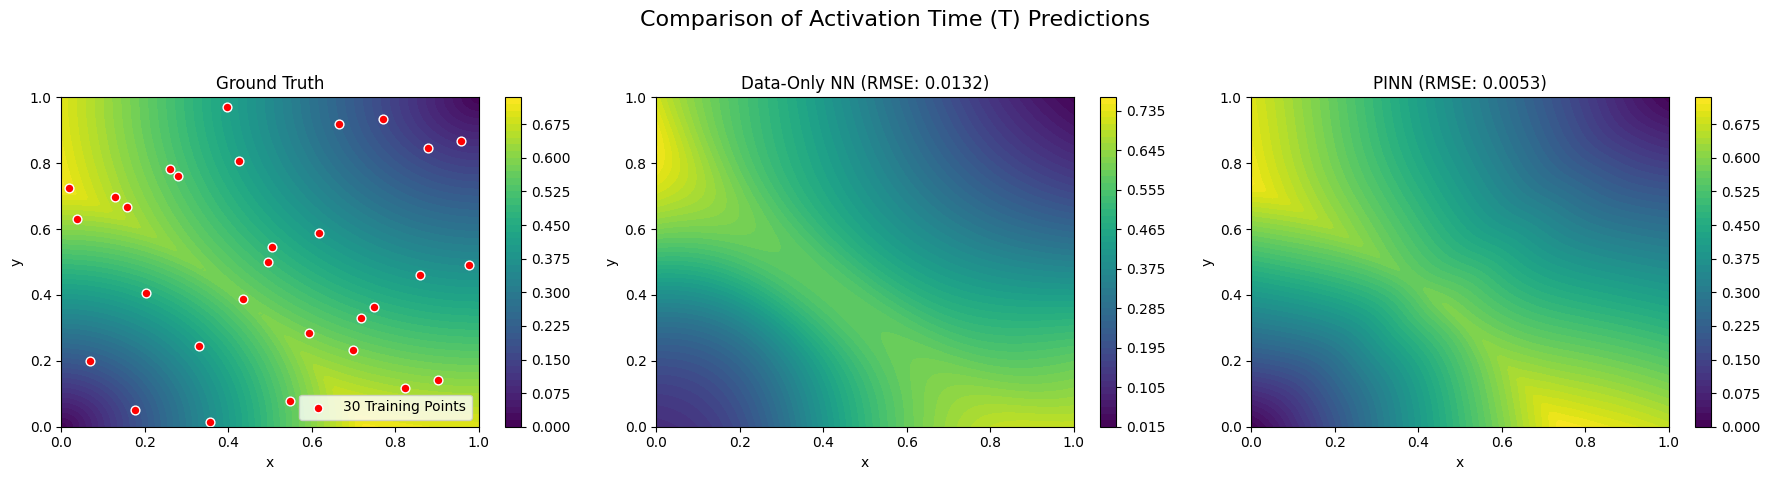

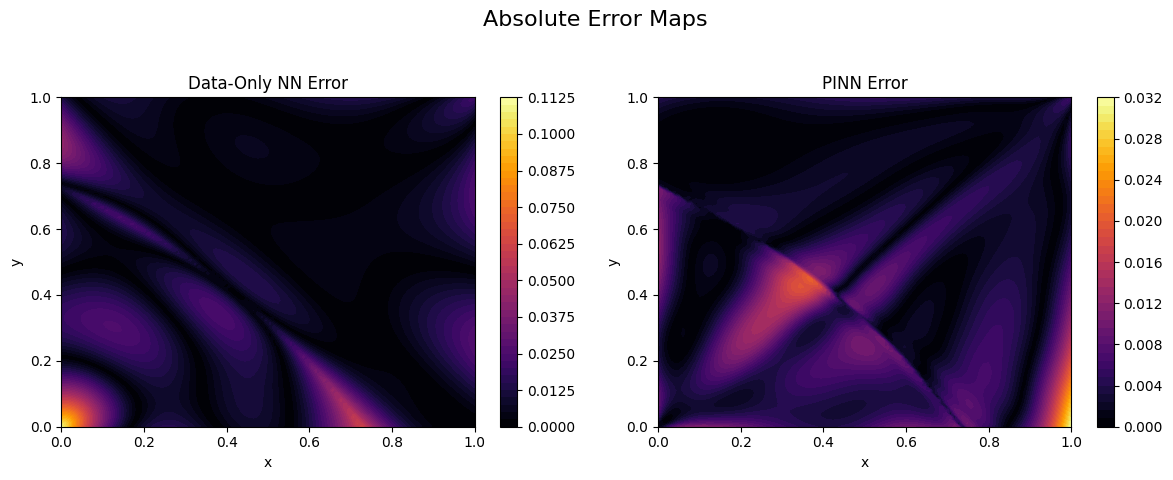

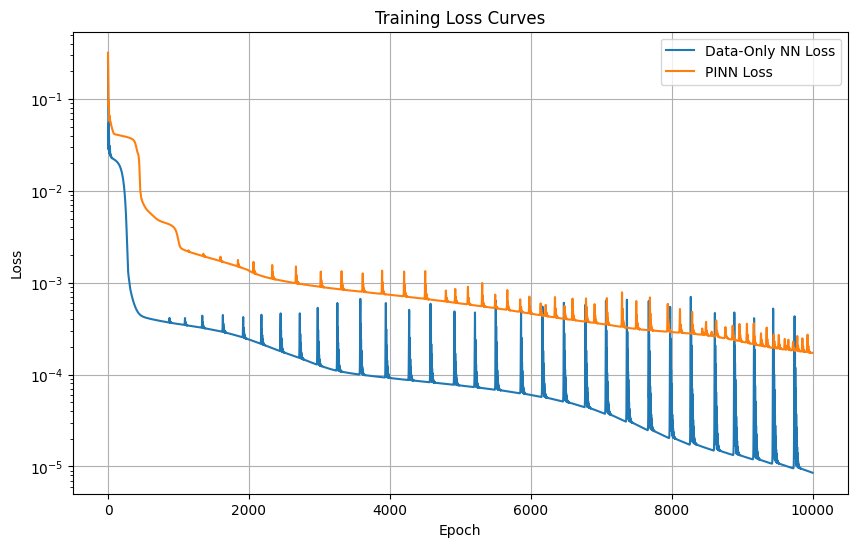

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Part A: Data Generation ---

def ground_truth_T(x, y):
    """
    Computes the ground truth activation time T(x,y).
    """
    return np.minimum(np.sqrt(x**2 + y**2), 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2))

def ground_truth_V(x, y):
    """
    Computes the conduction velocity V(x,y).
    """
    v = np.ones_like(x)
    mask = np.sqrt(x**2 + y**2) >= 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    v[mask] = 1.0 / 0.7
    return v

# Generate a grid for ground truth and visualization
grid_res = 100
x_range = np.linspace(0, 1, grid_res)
y_range = np.linspace(0, 1, grid_res)
xx, yy = np.meshgrid(x_range, y_range)
X_grid = np.vstack((xx.ravel(), yy.ravel())).T

# Calculate ground truth T and V on the grid
T_true = ground_truth_T(X_grid[:, 0], X_grid[:, 1]).reshape(grid_res, grid_res)
V_true = ground_truth_V(X_grid[:, 0], X_grid[:, 1]).reshape(grid_res, grid_res)

# Generate sparse training samples using Latin Hypercube Sampling 
n_train_samples = 30
sampler = LatinHypercube(d=2)

X_train_np = sampler.random(n=n_train_samples)
y_train_np = ground_truth_T(X_train_np[:, 0], X_train_np[:, 1])

# Convert numpy arrays to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32, requires_grad=True)

# Generate collocation points for the PINN physics loss
n_collocation = 5000
collocation_points = torch.rand((n_collocation, 2), requires_grad=True)

# --- Part B: Model Building ---

class FeedForwardNN(nn.Module):
    """
    A simple feedforward neural network.
    """
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

def train_model(model, optimizer, epochs, data_loss_weight, physics_loss_weight, is_pinn=False):
    """
    Generic training loop for both models.
    """
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Data Loss (MSE) 
        y_pred = model(X_train)
        loss_data = torch.mean((y_pred - y_train)**2)

        loss = data_loss_weight * loss_data

        # Physics Loss (Eikonal Residual) for PINN model 
        if is_pinn:
            T_pred_collocation = model(collocation_points)
            V_collocation = torch.tensor(ground_truth_V(collocation_points[:, 0].detach().numpy(),
                                                        collocation_points[:, 1].detach().numpy()),
                                         dtype=torch.float32).unsqueeze(1)

            # Compute gradient ||∇T|| using automatic differentiation 
            grad_T = torch.autograd.grad(T_pred_collocation, collocation_points,
                                         grad_outputs=torch.ones_like(T_pred_collocation),
                                         create_graph=True)[0]
            norm_grad_T = torch.sqrt(torch.sum(grad_T**2, dim=1, keepdim=True))

            # Eikonal residual 
            eikonal_residual = V_collocation * norm_grad_T - 1.0
            loss_physics = torch.mean(eikonal_residual**2)

            loss += physics_loss_weight * loss_physics

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Model: {'PINN' if is_pinn else 'Data-Only'}, Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

    return loss_history

# --- Model 1: Data-Driven Neural Network --- 
print("--- Training Model 1: Data-Driven NN ---")
model1 = FeedForwardNN()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
loss_history1 = train_model(model1, optimizer1, epochs=10000, data_loss_weight=1.0, physics_loss_weight=0, is_pinn=False)

# --- Model 2: Physics-Informed Neural Network (PINN) --- 
print("\n--- Training Model 2: PINN ---")
model2 = FeedForwardNN()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
# Weight for physics loss can be tuned. Here 0.1 is chosen.
loss_history2 = train_model(model2, optimizer2, epochs=10000, data_loss_weight=1.0, physics_loss_weight=0.1, is_pinn=True)

# --- Part C: Comparison and Visualization ---

# Get predictions on the grid
model1.eval()
model2.eval()
with torch.no_grad():
    T_pred1 = model1(X_grid_tensor).numpy().reshape(grid_res, grid_res)
    T_pred2 = model2(X_grid_tensor).numpy().reshape(grid_res, grid_res)

# Calculate errors (RMSE) 
rmse1 = np.sqrt(np.mean((T_pred1 - T_true)**2))
rmse2 = np.sqrt(np.mean((T_pred2 - T_true)**2))
print(f"\nRMSE for Data-Only Model: {rmse1:.4f}")
print(f"RMSE for PINN Model: {rmse2:.4f}")

# 1. Plot Activation Maps 
plt.figure(figsize=(18, 5))
plt.suptitle("Comparison of Activation Time (T) Predictions", fontsize=16)

plt.subplot(1, 3, 1)
plt.contourf(xx, yy, T_true, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Ground Truth")
plt.xlabel("x")
plt.ylabel("y")
# Plot sparse data points
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c='red', s=40, edgecolors='white', label=f'{n_train_samples} Training Points')
plt.legend()


plt.subplot(1, 3, 2)
plt.contourf(xx, yy, T_pred1, levels=50, cmap='viridis')
plt.colorbar()
plt.title(f"Data-Only NN (RMSE: {rmse1:.4f})")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 3, 3)
plt.contourf(xx, yy, T_pred2, levels=50, cmap='viridis')
plt.colorbar()
plt.title(f"PINN (RMSE: {rmse2:.4f})")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("q1_activation_maps.png")
print("\nSaved activation map comparison to q1_activation_maps.png")

# 2. Plot Error Maps 
error1 = np.abs(T_pred1 - T_true)
error2 = np.abs(T_pred2 - T_true)

plt.figure(figsize=(12, 5))
plt.suptitle("Absolute Error Maps", fontsize=16)

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, error1, levels=50, cmap='inferno')
plt.colorbar()
plt.title(f"Data-Only NN Error")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, error2, levels=50, cmap='inferno')
plt.colorbar()
plt.title(f"PINN Error")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("q1_error_maps.png")
print("Saved error map comparison to q1_error_maps.png")


# 3. Plot Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(loss_history1, label='Data-Only NN Loss')
plt.plot(loss_history2, label='PINN Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig("q1_loss_curves.png")
print("Saved loss curves to q1_loss_curves.png")

plt.show()

# **Question 2**

In [7]:
pip install torchdiffeq

  Using cached torchdiffeq-0.2.5-py3-none-any.whl.metadata (440 bytes)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torchdiffeq-0.2.5-py3-none-any.whl (32 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.9.5
    Uninstalling nvidia-cuspars

--- Training Standard Neural Network ---
Epoch 50/300, Loss: 0.2524, Accuracy: 0.8743
Epoch 100/300, Loss: 0.1793, Accuracy: 0.9371
Epoch 150/300, Loss: 0.1086, Accuracy: 0.9714
Epoch 200/300, Loss: 0.0749, Accuracy: 0.9771
Epoch 250/300, Loss: 0.0597, Accuracy: 0.9800
Epoch 300/300, Loss: 0.0511, Accuracy: 0.9829
Standard NN Final Test Accuracy: 0.9800

--- Training Neural ODE Classifier ---
Epoch 50/300, Loss: 0.2891, Accuracy: 0.8486
Epoch 100/300, Loss: 0.2750, Accuracy: 0.8629
Epoch 150/300, Loss: 0.1443, Accuracy: 0.9429
Epoch 200/300, Loss: 0.0537, Accuracy: 0.9743
Epoch 250/300, Loss: 0.0343, Accuracy: 0.9829
Epoch 300/300, Loss: 0.0282, Accuracy: 0.9800
Neural ODE Final Test Accuracy: 0.9733

Saved decision boundary plot to q2_decision_boundaries.png
Saved accuracy/loss plot to q2_accuracy_loss.png


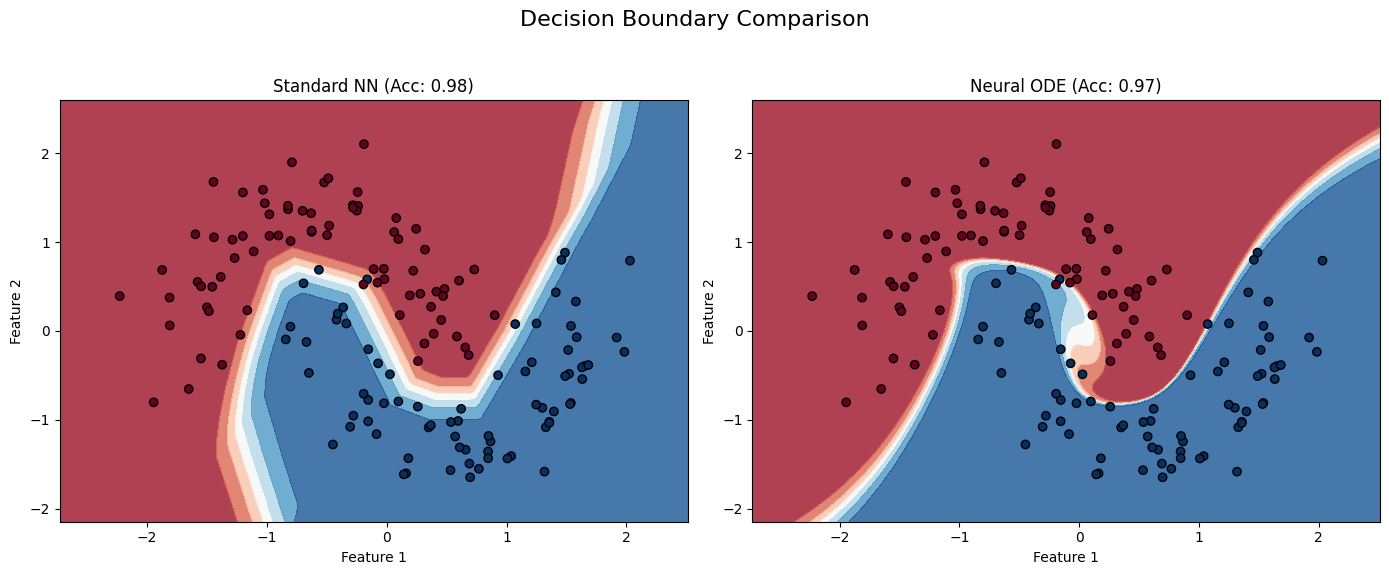

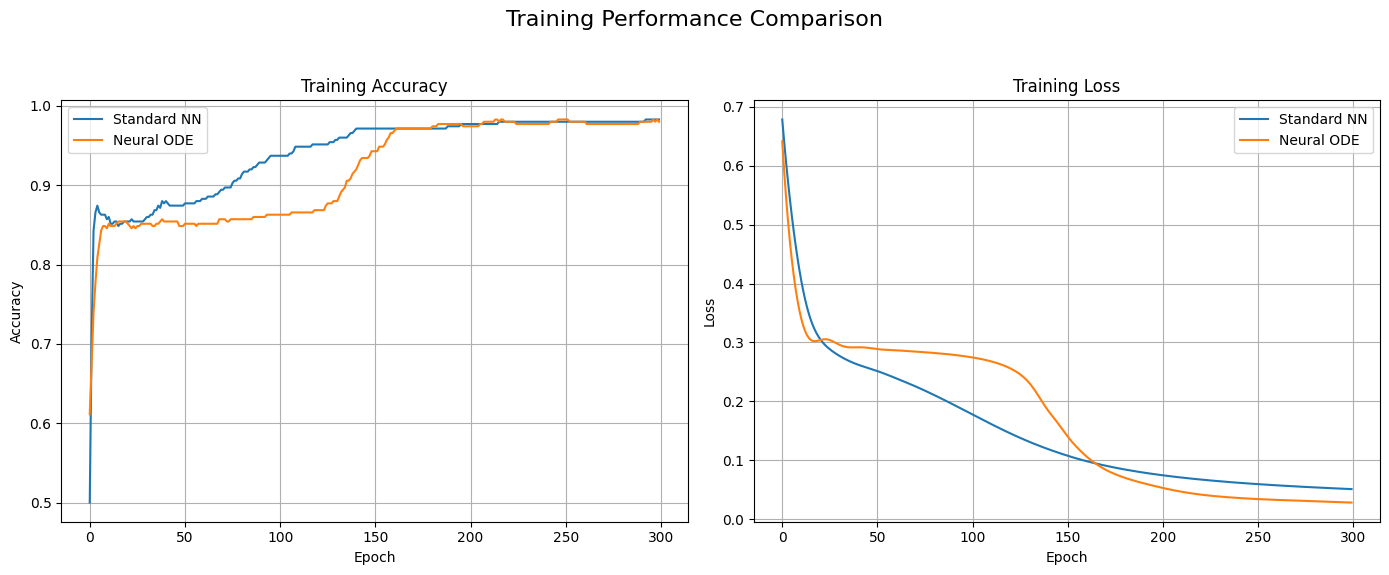

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchdiffeq import odeint

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Part A: Baseline Model (Standard NN) ---

# 1. Create a 2D toy dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 2. Define the standard 1-hidden-layer network
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # One hidden layer with 32 neurons
            nn.ReLU(),       # ReLU activation
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Part B: Neural ODE Model ---

# 1. Define the ODE dynamics function f(h, t)
class ODEDynamics(nn.Module):
    def __init__(self):
        super(ODEDynamics, self).__init__()
        # f is a small neural network
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, t, h):
        # The first argument to forward is time t, the second is the hidden state h
        return self.net(h)

# 2. Define the Neural ODE block
class NeuralODE(nn.Module):
    def __init__(self, dynamics_func):
        super(NeuralODE, self).__init__()
        self.dynamics_func = dynamics_func
        # Define the time interval over which to solve the ODE
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32)

    def forward(self, x):
        # Evolve the hidden state from t=0 to t=1
        # Use rk4 or dopri5 solver from torchdiffeq
        out = odeint(self.dynamics_func, x, self.integration_time, method='dopri5')
        # The output is the hidden state at t=1
        return out[1]

# 3. Create the full Neural ODE classifier
class NeuralODEClassifier(nn.Module):
    def __init__(self):
        super(NeuralODEClassifier, self).__init__()
        # The Neural ODE replaces the hidden layer
        self.neural_ode = NeuralODE(ODEDynamics())
        # A final linear layer for classification
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        h = self.neural_ode(x)
        return self.fc(h)

# --- Training and Comparison ---

def train(model, optimizer, epochs=300):
    """
    A generic training function for both models.
    """
    criterion = nn.BCEWithLogitsLoss()
    loss_history = []
    acc_history = []
    
    for epoch in range(epochs):
        model.train()
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        with torch.no_grad():
            pred_labels = torch.sigmoid(y_pred) > 0.5
            accuracy = (pred_labels.float() == y_train).float().mean()
            acc_history.append(accuracy.item())
            loss_history.append(loss.item())
            
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
            
    return loss_history, acc_history

def test(model):
    """
    Evaluates the model on the test set.
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        pred_labels = torch.sigmoid(y_pred) > 0.5
        accuracy = (pred_labels.float() == y_test).float().mean()
    return accuracy.item()


# Train and evaluate the Standard NN
print("--- Training Standard Neural Network ---")
model_std = StandardNN()
optimizer_std = optim.Adam(model_std.parameters(), lr=0.01)

loss_std, acc_std = train(model_std, optimizer_std)
test_acc_std = test(model_std)
print(f"Standard NN Final Test Accuracy: {test_acc_std:.4f}\n")

# Train and evaluate the Neural ODE Classifier
print("--- Training Neural ODE Classifier ---")
model_node = NeuralODEClassifier()
optimizer_node = optim.Adam(model_node.parameters(), lr=0.01)
# --- THIS LINE IS CORRECTED ---
loss_node, acc_node = train(model_node, optimizer_node)
test_acc_node = test(model_node)
print(f"Neural ODE Final Test Accuracy: {test_acc_node:.4f}\n")

# --- Part C: Visualization and Comparison ---

def plot_decision_boundary(model, X, y, ax, title):
    """
    Helper function to plot decision boundaries.
    """
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    with torch.no_grad():
        Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
        Z = torch.sigmoid(Z).reshape(xx.shape)
        
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

# 1. Plot Decision Boundaries
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Decision Boundary Comparison", fontsize=16)
plot_decision_boundary(model_std, X_test.numpy(), y_test.numpy().flatten(), axes[0], f"Standard NN (Acc: {test_acc_std:.2f})")
plot_decision_boundary(model_node, X_test.numpy(), y_test.numpy().flatten(), axes[1], f"Neural ODE (Acc: {test_acc_node:.2f})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("q2_decision_boundaries.png")
print("Saved decision boundary plot to q2_decision_boundaries.png")


# 2. Plot Accuracy and Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Training Performance Comparison", fontsize=16)

axes[0].plot(acc_std, label='Standard NN')
axes[0].plot(acc_node, label='Neural ODE')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(loss_std, label='Standard NN')
axes[1].plot(loss_node, label='Neural ODE')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("q2_accuracy_loss.png")
print("Saved accuracy/loss plot to q2_accuracy_loss.png")

plt.show()